# Plotting Relative Entropy

The following code generates Figure 10

In [1]:
import os
os.chdir(f'{os.getcwd()}/../../')
WORKING_DIR = './evaluation/uspc'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import torch
import configs
import numpy as np
import pandas as pd
from tqdm import tqdm

from datasets.xihe.loader import XiheTestDataset
from datasets.xihe.loader import XiheFPSTestDataset
from datasets.pointar.loader import PointARTestDataset

from utils3d import fibonacci_sphere
from utils3d import cartesian_to_spherical
from utils3d import spherical_to_cartesian

import seaborn as sns
from matplotlib import pyplot as plt
sns.set(color_codes=True)

In [5]:
data_root = configs.pointar_dataset_path
jec = JointEntropyCalculator([2 ** (i + 1) for i in range(11)])
# jec = JointEntropyCalculator([2 ** (i + 1) for i in range(6, 11)])
jpc = JointPercentageCalculator([2 ** (i + 1) for i in range(11)])
df_test = pd.DataFrame(columns=['n_points', 'ground_truth', 'uniform', 'sphere', 'fps'])

In [6]:
for n_anchors in [512, 768, 1024, 1280, 1536, 1792, 2048]:
    du_test = PointARTestDataset(n_points=n_anchors)
    ds_test = XiheTestDataset(n_points=n_anchors)
    fps_test = XiheFPSTestDataset(n_points=n_anchors)
    
    for i in tqdm(range(len(ds_test))):
        x = torch.from_numpy(np.load(f'{data_root}/test/{i}/point_cloud.npz')['point_cloud'])
        x -= np.array([0, 0.1, 0, 0, 0, 0], dtype=np.float32)
        x = x[:, :3].transpose(0, 1)
        s = torch.linalg.norm(x, dim=0)
        gtpc = x[:, s > 0].transpose(0, 1).cuda()
#         egt = jpc.forward(gtpc)
        egt = jec.forward(gtpc)

        
        x, _ = du_test[i]
        xyz, _ = x
        s = torch.linalg.norm(xyz, dim=0)
        pc = xyz[:, s > 0].transpose(0, 1).cuda()
#         eu = jpc.forward(pc)
        eu = jec.forward(pc)

        
        x, _ = ds_test[i]
        xyz, _ = x
        s = torch.linalg.norm(xyz, dim=0)
        pc = xyz[:, s > 0].transpose(0, 1).cuda()
#         es = jpc.forward(pc)
        es = jec.forward(pc)

        
        x, _ = fps_test[i]
        xyz, _ = x
        s = torch.linalg.norm(xyz, dim=0)
        pc = xyz[:, s > 0].transpose(0, 1).cuda()
#         ef = jpc.forward(pc)
        ef = jec.forward(pc)

        df_test.loc[len(df_test)] = [str(n_anchors), egt, eu, es, ef]

100%|██████████| 2037/2037 [02:01<00:00, 16.74it/s]


In [7]:
df_test.to_csv(f'{WORKING_DIR}/results/test.csv')

# Plots

In [8]:
df = pd.read_csv(f'{WORKING_DIR}/results/test.csv', index_col=0)

In [9]:
# df_fg = pd.DataFrame.from_dict({
#     'Unit Sphere': pd.Series((df[['sphere']].values / df[['ground_truth']].values)[:, 0]),
#     'Uniform Random [7]': pd.Series((df[['uniform']].values / df[['ground_truth']].values)[:, 0])
# })

df_fg = pd.DataFrame(columns=['n_points', 'sampling_method', 'normalized_entropy'])

for n_points in [512, 768, 1024, 1280, 1536, 1792, 2048]:
    
    t = df[df['n_points'] == n_points]

    df_fg.loc[len(df_fg)] = [
        n_points,
        'Ours',
        (t['sphere'] / t['ground_truth']).mean()
    ]
    
    df_fg.loc[len(df_fg)] = [
        n_points,
        'FPS',
        (t['fps'] / t['ground_truth']).mean()
    ]
    
    df_fg.loc[len(df_fg)] = [
        n_points,
        'Uniform Random [7]',
        (t['uniform'] / t['ground_truth']).mean()
    ]

<ipython-input-29-1688ee98e892>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.around(ax.get_yticks(), decimals=1), size=16)


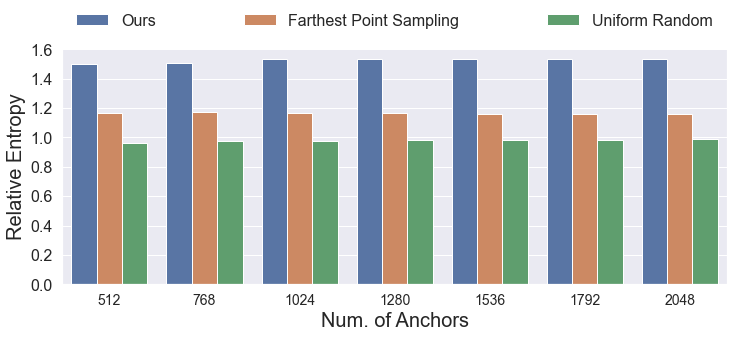

In [29]:
plt.figure(figsize=(10, 4.5))

ax = sns.barplot(data=df_fg, x='n_points', y='normalized_entropy', hue='sampling_method')

# num_locations = 7
# hatches = itertools.cycle(['/', '//'])
# for i, bar in enumerate(ax.patches):
#     if i % num_locations == 0:
#         hatch = next(hatches)
#     bar.set_hatch(hatch)

l = ax.legend(
    loc='lower center', fontsize=16, ncol=3,
    bbox_to_anchor=(0., 1.02, 1., .102), mode='expand',
    edgecolor=(0, 0, 0, 0),
    facecolor=(0, 0, 1, 0.0)
)
l.get_frame().set_alpha(None)
# ax.get_legend().set_title('Sampling Method')
plt.setp(ax.get_legend().get_title(), fontsize=18)

l.get_texts()[0].set_text('Ours')
l.get_texts()[1].set_text('Farthest Point Sampling')
l.get_texts()[2].set_text('Uniform Random')

ax.set_xlabel('Num. of Anchors', fontsize=20)
ax.set_ylabel('Relative Entropy', fontsize=20)

# ax.set_ylim(0.5, 1.0)

ax.set_xticklabels(ax.get_xticklabels(), size=14)
ax.set_yticklabels(np.around(ax.get_yticks(), decimals=1), size=16)

plt.tight_layout(pad=0)
plt.savefig(f'{WORKING_DIR}/figures/completeness_sampling_entropy.pdf')  

In [31]:
(df_fg[df_fg['sampling_method'] == 'Ours'][['normalized_entropy']].values -
 df_fg[df_fg['sampling_method'] == 'Uniform Random [7]'][['normalized_entropy']].values).mean()

array([[0.55585327],
       [0.54562894],
       [0.56822214],
       [0.56253905],
       [0.55760004],
       [0.55655409],
       [0.55518037]])

In [36]:
((df_fg[df_fg['sampling_method'] == 'Ours'][['normalized_entropy']].values -
 df_fg[df_fg['sampling_method'] == 'Uniform Random [7]'][['normalized_entropy']].values) /
    df_fg[df_fg['sampling_method'] == 'Uniform Random [7]'][['normalized_entropy']].values).mean() * 100

55.73682723818566

In [28]:
(df_fg[df_fg['sampling_method'] == 'Ours'][['normalized_entropy']].values -
 df_fg[df_fg['sampling_method'] == 'FPS'][['normalized_entropy']].values).mean()

0.35885593725002857

In [37]:
((df_fg[df_fg['sampling_method'] == 'Ours'][['normalized_entropy']].values -
 df_fg[df_fg['sampling_method'] == 'FPS'][['normalized_entropy']].values) / 
 df_fg[df_fg['sampling_method'] == 'FPS'][['normalized_entropy']].values).mean() * 100

30.80341927615104